In [1]:
import pickle
import numpy as np
import xarray as xa
import cartopy
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import scipy.stats
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import pandas as pd

In [2]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)
data = xa.open_dataarray('/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip')
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))
ext_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    q1 = np.quantile(precip_data[precip_data > 1], 0.05)
    q2 = np.quantile(precip_data[precip_data > 1], 0.95)
    ext_time = precip.where(precip > q2, drop=True).time.data
    print(len(ext_time), q2)
    ext_days[sub_id] = ext_time


sub_id:  1
39 21.363590636973544
sub_id:  2
38 7.98353434112839
sub_id:  3
37 7.6309751208430425
sub_id:  4
77 6.2968948209451305
sub_id:  5
118 6.469523059079158
sub_id:  6
124 10.647874758983226
sub_id:  7
153 17.252742222601025


# Number of Events

* Events, consecutive days are counted as one event

In [3]:
def mk_score(x, n):
    s = 0
    demo = np.ones(n)
    for k in range(n-1):
        s = s+np.sum(demo[k+1:n][x[k+1:n] > x[k]])-np.sum(demo[k+1:n][x[k+1:n] < x[k]])
    return s

def variance_s(x, n):
    unique_x = np.unique(x)
    g = len(unique_x)
    if n==g:
        var_s = (n*(n-1)*(2*n+5))/18
    else:
        tp = np.zeros(unique_x.shape)
        demo = np.ones(n)
        for i in range(g):
            tp[i] = np.sum(demo[x==unique_x[i]])
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18
    return var_s

def z_score(s, var_s):
    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    return z

def p_value(z, alpha):
    # two tail test
    p = 2*(1-norm.cdf(abs(z)))  
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    
    return p, h, trend

In [4]:
def sens_slope(x):
    n = len(x)
    slope = np.nanmedian(sens_estimator(x))
    intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
    
    return slope, intercept
def sens_estimator(x):
    idx = 0
    n = len(x)
    print(n)
    d = np.ones(int(n*(n-1)/2))

    for i in range(n-1):
        j = np.arange(i+1,n) # all the combination of two points selected from original series. 
        d[idx : idx + len(j)] = (x[j] - x[i]) / (j - i)
        idx = idx + len(j)
        # print(i, idx)
    return d

In [5]:
def start_end_time(sub_id):
    start = []
    end = []
    ext_times = ext_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        j = 1
        while (j + i <= length - 1) and ((ext_times[i + j] - ext_times[i + j - 1]) / np.timedelta64(1, "D") == 1):
            j += 1
        start.append(ext_times[i] - np.timedelta64(12, "h"))
        end.append(ext_times[i + j - 1] + np.timedelta64(12, "h"))
        i += j
    return start, end

# Find categories

In [6]:
def find_categories_events(label, end):
    years = np.arange(1979, 2019)
    cate_end = []
    for i in range(len(end)):
        if label[i]>0:
            cate_end.append(end[i])
    cate_year = [pd.to_datetime(t).year for t in cate_end]
    print(cate_year)
    n_epes = []
    for year in years:
        n_epes.append(cate_year.count(year))
    return n_epes

# Sub1

31
40
0.03787812392593071 True increasing
0.0 1.0


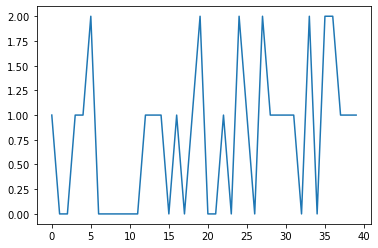

In [7]:
sub_id = 1
n_epe = []
epe_tutt = []
epe_mcs = []
epe_tc = []
epe_front = []
epe_surge = []
epe_midtro = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    start, end = start_end_time(sub_id)
    time_end = [pd.to_datetime(t).year for t in end]
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    n_epe.append(time_end.count(year))

n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)
plt.plot(n_epe)
plt.show()

In [8]:
import statsmodels.api as sm
from scipy import stats

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.851
Date:                Sat, 18 Jun 2022   Prob (F-statistic):             0.0338
Time:                        10:32:52   Log-Likelihood:                -41.444
No. Observations:                  40   AIC:                             86.89
Df Residuals:                      38   BIC:                             90.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3634      0.217      1.673      0.1

In [9]:
model = LinearRegression().fit(np.arange(n).reshape(-1, 1), n_epe)
print(model.coef_)


[0.02110694]


## categories

In [10]:
sub_id = 1
surge_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
# tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
# tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
MCS_induced_flag = np.load("ERA5/PAU/MCS_" + str(sub_id) + ".npy")
MCS_induced_flag[MCS_induced_flag < 0] = 0
midtro_flag = np.load("ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
front_flag = np.load("ERA5/PAU/" + str(sub_id) + "_front.npy")
start, end = start_end_time(sub_id)
all_time = ext_days[sub_id]

[1982, 1984, 1993, 1995, 1997, 2001, 2003, 2003, 2006, 2006, 2007, 2008, 2009, 2010, 2012, 2014, 2014, 2015, 2016, 2017]


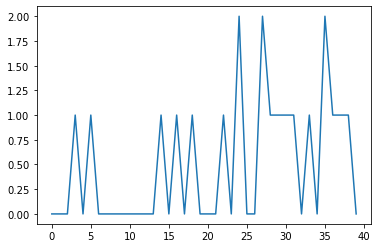

20
40
0.010267104695776741 False no trend
0.0 0.0


In [11]:
# TC
n_epe = find_categories_events(tc_induced_flag, end)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

[1991, 1995, 1997, 1998, 2003, 2006, 2012, 2014, 2015, 2016]


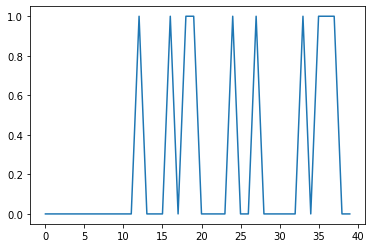

10
40
0.05473961622978374 False no trend
0.0 0.0


In [12]:
n_epe = find_categories_events(tutt_induced_flag, end)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

[1982, 1997, 2001]


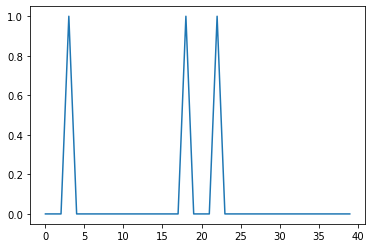

3
40
0.44115502039856547 False no trend
0.0 0.0


In [13]:
n_epe = find_categories_events(midtro_flag, end)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

[2004, 2006, 2006, 2012, 2012, 2014, 2015, 2017, 2018]


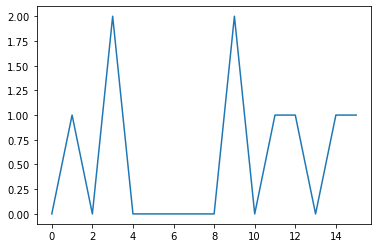

9
16
0.35811775361995113 False no trend
0.0 0.0


In [14]:
n_epe = find_categories_events(MCS_induced_flag, end)
n_epe = n_epe[2003-1979:]
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

[2015]


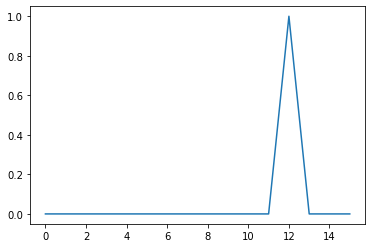

1
16
0.385546631571102 False no trend
0.0 0.0


In [15]:
n_epe = find_categories_events(front_flag, end)
n_epe = n_epe[2003-1979:]
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

# Sub2

In [16]:
sub_id = 2
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    start, end = start_end_time(sub_id)
    time_end = [pd.to_datetime(t).year for t in end]
    n_epe.append(time_end.count(year))
print(np.sum(n_epe))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

29
40
0.14411966888671857 False no trend
0.0 0.0


In [17]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.222
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.276
Time:                        10:32:53   Log-Likelihood:                -57.088
No. Observations:                  40   AIC:                             118.2
Df Residuals:                      38   BIC:                             121.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0305      0.321      3.209      0.0

# Sub3

In [18]:
sub_id = 3
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    start, end = start_end_time(sub_id)
    time_end = [pd.to_datetime(t).year for t in end]
    n_epe.append(time_end.count(year))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]), ' ', len(end))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

29   37   29
40
0.1386633187830426 False no trend
0.0 0.0


In [19]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9667
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.332
Time:                        10:32:54   Log-Likelihood:                -57.219
No. Observations:                  40   AIC:                             118.4
Df Residuals:                      38   BIC:                             121.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9976      0.322      3.097      0.0

# Sub4

In [20]:
sub_id = 4
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    start, end = start_end_time(sub_id)
    time_end = [pd.to_datetime(t).year for t in end]
    n_epe.append(time_end.count(year))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]), len(end))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

64   77 64
40
0.12148974988719896 False no trend
0.0 1.5


In [21]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     4.079
Date:                Sat, 18 Jun 2022   Prob (F-statistic):             0.0505
Time:                        10:32:54   Log-Likelihood:                -66.914
No. Observations:                  40   AIC:                             137.8
Df Residuals:                      38   BIC:                             141.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8866      0.411      2.160      0.0

# Sub5

In [22]:
sub_id = 5
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    start, end = start_end_time(sub_id)
    time_end = [pd.to_datetime(t).year for t in end]
    n_epe.append(time_end.count(year))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]), ' ', len(end))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

86   118   86
40
0.39205415845336544 False no trend
0.0 2.0


In [23]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.986
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.167
Time:                        10:32:55   Log-Likelihood:                -72.634
No. Observations:                  40   AIC:                             149.3
Df Residuals:                      38   BIC:                             152.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5756      0.474      3.327      0.0

# Sub6

In [24]:
sub_id = 6
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    start, end = start_end_time(sub_id)
    time_end = [pd.to_datetime(t).year for t in end]
    n_epe.append(time_end.count(year))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]), len(end))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

105   124 105
40
0.043526836964626225 True increasing
0.05 1.025


In [25]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.128
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.295
Time:                        10:32:55   Log-Likelihood:                -83.312
No. Observations:                  40   AIC:                             170.6
Df Residuals:                      38   BIC:                             174.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0598      0.619      3.330      0.0

In [26]:
model = LinearRegression().fit(np.arange(n).reshape(-1, 1), n_epe)
print(model.coef_)

[0.02898687]


## categories

In [27]:
sub_id = 6
surge_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
# tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
# tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
MCS_induced_flag = np.load("ERA5/PAU/MCS_" + str(sub_id) + ".npy")
MCS_induced_flag[MCS_induced_flag < 0] = 0
midtro_flag = np.load("ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
front_flag = np.load("ERA5/PAU/" + str(sub_id) + "_front.npy")
start, end = start_end_time(sub_id)
all_time = ext_days[sub_id]

[1984, 1992, 1996, 1998, 2001, 2003, 2003, 2006, 2006, 2007, 2008, 2009, 2010, 2013, 2014, 2014, 2015, 2016, 2016, 2017]


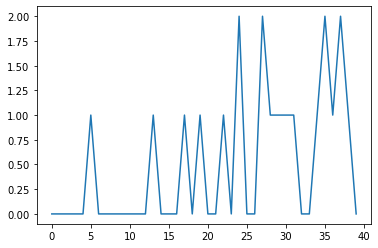

20
40
0.0012961453340483153 True increasing
0.0 0.0


In [28]:
# TC
n_epe = find_categories_events(tc_induced_flag, end)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

[1979, 1979, 1979, 1980, 1983, 1984, 1984, 1986, 1986, 1986, 1987, 1990, 1990, 1990, 1990, 1991, 1993, 1993, 1995, 1995, 1996, 1997, 1998, 1998, 2002, 2003, 2003, 2006, 2010, 2010, 2011, 2012, 2012, 2013, 2013, 2015, 2015, 2015, 2015, 2016, 2016, 2017, 2017, 2018, 2018, 2018]


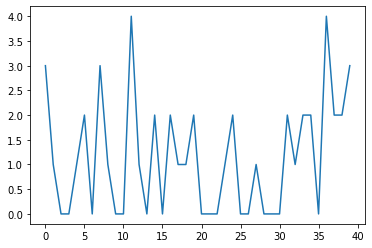

46
40
0.37733892148535086 False no trend
0.0 1.0


In [29]:
n_epe = find_categories_events(tutt_induced_flag, end)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

[1979, 1979, 1979, 1979, 1980, 1981, 1983, 1983, 1983, 1983, 1983, 1984, 1984, 1984, 1985, 1985, 1986, 1986, 1986, 1986, 1987, 1989, 1990, 1990, 1990, 1990, 1990, 1990, 1992, 1993, 1993, 1994, 1995, 1995, 1996, 1996, 1998, 1998, 2001, 2002, 2003, 2003, 2003, 2003, 2004, 2004, 2004, 2005, 2006, 2006, 2006, 2006, 2007, 2008, 2008, 2009, 2010, 2010, 2010, 2010, 2012, 2013, 2013, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2015, 2015, 2016, 2016, 2016, 2017, 2017, 2017, 2018, 2018, 2018]


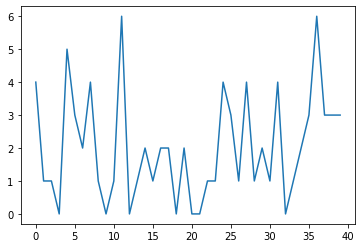

81
40
0.2881051849009637 False no trend
0.0 2.0


In [30]:
n_epe = find_categories_events(surge_induced_flag, end)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

[1983, 1985, 1992, 1998, 2004, 2004]


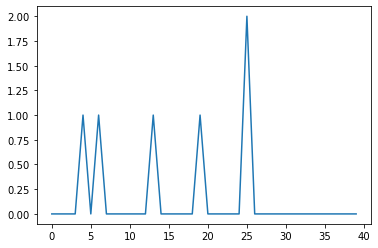

6
40
0.25296610456745805 False no trend
0.0 0.0


In [31]:
n_epe = find_categories_events(midtro_flag, end)
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

[2002, 2003, 2004, 2004, 2004, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2010, 2010, 2011, 2012, 2012, 2013, 2013, 2014, 2014, 2015, 2015, 2015, 2015, 2016, 2016, 2017, 2017, 2017, 2017, 2018, 2018]


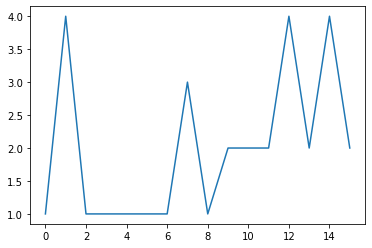

32
16
0.037813874720570295 False no trend
0.09090909090909091 1.3181818181818181


In [32]:
n_epe = find_categories_events(MCS_induced_flag, end)
n_epe = n_epe[2003-1979:]
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

[2004, 2004, 2004, 2006, 2006, 2006, 2007, 2010, 2010, 2012, 2014, 2014, 2015, 2015, 2016, 2017, 2018]


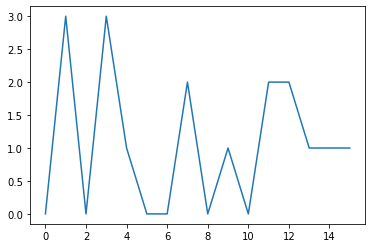

17
16
0.7757557340067254 False no trend
0.0 1.0


In [33]:
n_epe = find_categories_events(front_flag, end)
n_epe = n_epe[2003-1979:]
plt.plot(n_epe)
plt.show()
n = len(n_epe)
print(np.sum(n_epe))
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

# Sub7

In [34]:
sub_id = 7
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    start, end = start_end_time(sub_id)
    time_end = [pd.to_datetime(t).year for t in end]
    n_epe.append(time_end.count(year))
print(np.sum(n_epe), ' ', len(ext_days[sub_id]), ' ', len(end))
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

136   153   136
40
0.33991708243329377 False no trend
0.0 3.0


In [35]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.394
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.130
Time:                        10:32:56   Log-Likelihood:                -86.866
No. Observations:                  40   AIC:                             177.7
Df Residuals:                      38   BIC:                             181.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3000      0.676      6.361      0.0

# Precipitation Amount

In [36]:
def find_categories_precip(label, end, sub_id):
    ext_time = ext_days[sub_id]
    precip_year = np.zeros(40)
    for time in ext_time:
        year = pd.to_datetime(time).year
        current_time = time+np.timedelta64(12, 'h')
        while current_time not in end:
            current_time = current_time + np.timedelta64(1, 'D')
        ind = end.index(current_time)
        if label[ind]>0:
            # print('here')
            precip_year[year-1979]+=monsoon_precip.sel(sub_id=sub_id).sel(time=time)

    return precip_year

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 1.]


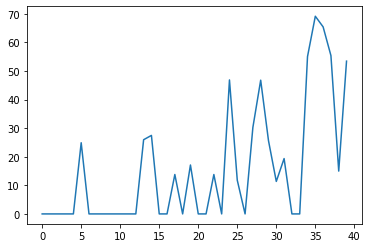

In [37]:
tc_induced_flag = np.load("ERA5/PAU/" + str(6) + "_tc_induced_flag.npy")
print(tc_induced_flag)
start, end = start_end_time(sub_id=6)
precip_year = find_categories_precip(tc_induced_flag, end, sub_id=6)
plt.plot(precip_year)

# Sub1

In [38]:
sub_id = 1
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

40
0.02262536212899602 True increasing
0.8703217656121727 8.199267140507988


In [39]:
X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     5.271
Date:                Sat, 18 Jun 2022   Prob (F-statistic):             0.0273
Time:                        10:32:57   Log-Likelihood:                -203.59
No. Observations:                  40   AIC:                             411.2
Df Residuals:                      38   BIC:                             414.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1036     12.512      0.887      0.3

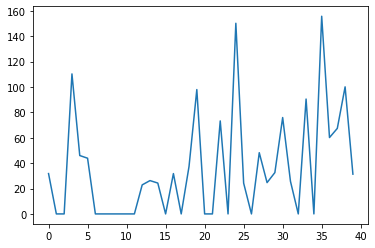

In [40]:
plt.plot(n_epe)

## categories

In [41]:
sub_id = 1
surge_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
# tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
# tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
MCS_induced_flag = np.load("ERA5/PAU/MCS_" + str(sub_id) + ".npy")
MCS_induced_flag[MCS_induced_flag < 0] = 0
midtro_flag = np.load("ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
front_flag = np.load("ERA5/PAU/" + str(sub_id) + "_front.npy")
start, end = start_end_time(sub_id)
all_time = ext_days[sub_id]

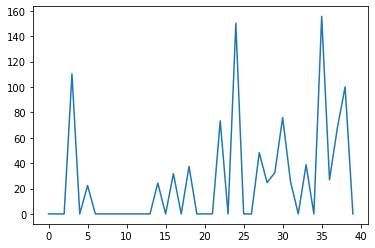

40
0.004287725722426972 True increasing
0.0 0.0


In [42]:
precip_year = find_categories_precip(tc_induced_flag, end, sub_id=1)
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

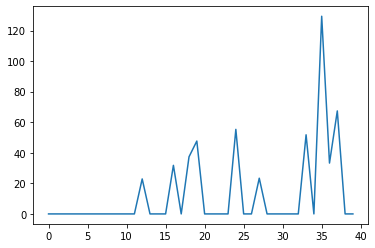

40
0.0246941553494886 False no trend
0.0 0.0


In [43]:
precip_year = find_categories_precip(tutt_induced_flag, end, sub_id=1)
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

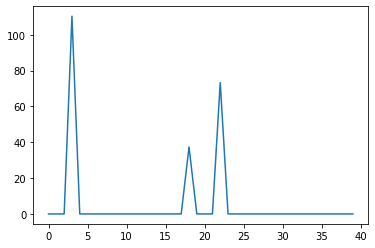

40
0.42663740516278725 False no trend
0.0 0.0


In [44]:
precip_year = find_categories_precip(midtro_flag, end, sub_id=1)
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

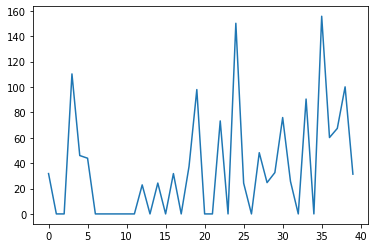

40
0.017852008555653942 False no trend
0.8066560925324975 8.767680559843075


In [45]:
precip_year = find_categories_precip(surge_induced_flag, end, sub_id=1)
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

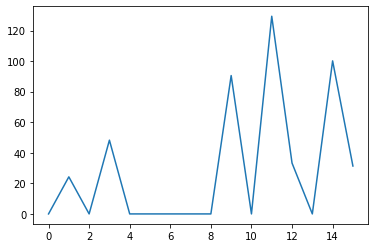

16
0.1777369996906002 False no trend
0.0 0.0


In [46]:
precip_year = find_categories_precip(MCS_induced_flag, end, sub_id=1)
precip_year = precip_year[2003-1979:]
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

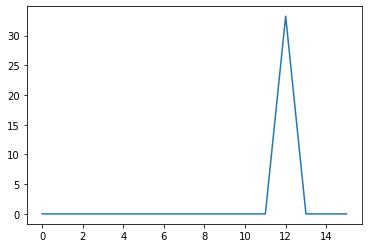

16
0.385546631571102 False no trend
0.0 0.0


In [47]:
precip_year = find_categories_precip(front_flag, end, sub_id=1)
precip_year = precip_year[2003-1979:]
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

# Sub2

In [48]:
sub_id = 2
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.07921221657854227 False no trend
0.0 0.0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.820
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.101
Time:                        10:32:59   Log-Likelihood:                -172.01
No. Observations:                  40   AIC:                             348.0
Df Residuals:                      38   BIC:                             351.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

# Sub3

In [49]:
sub_id = 3
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.16087806893207057 False no trend
0.0 0.0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.733
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.107
Time:                        10:32:59   Log-Likelihood:                -164.03
No. Observations:                  40   AIC:                             332.1
Df Residuals:                      38   BIC:                             335.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

# Sub4

In [50]:
sub_id = 4
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.14927118153783514 False no trend
0.2412777143351921 9.044585832944767
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.295
Date:                Sat, 18 Jun 2022   Prob (F-statistic):             0.0451
Time:                        10:32:59   Log-Likelihood:                -163.98
No. Observations:                  40   AIC:                             332.0
Df Residuals:                      38   BIC:                             335.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

(array([ 6.,  8., 10.,  4.,  4.,  2.,  3.,  1.,  1.,  1.]),
 array([-4.5991    ,  1.91165735,  8.42241471, 14.93317206, 21.44392941,
        27.95468676, 34.46544412, 40.97620147, 47.48695882, 53.99771618,
        60.50847353]),
 <BarContainer object of 10 artists>)

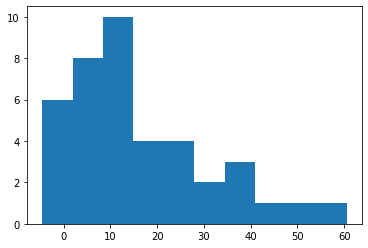

In [51]:
res = np.array(n_epe)-0.4251*np.arange(n)+8.1539
plt.hist(res)

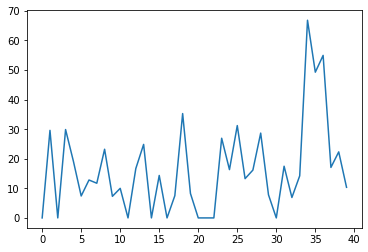

In [52]:
plt.plot(n_epe)

# Sub5

In [53]:
sub_id = 5
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.9257196644596948 False no trend
-0.018335334972307868 21.82985987541472
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7370
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.396
Time:                        10:33:00   Log-Likelihood:                -176.81
No. Observations:                  40   AIC:                             357.6
Df Residuals:                      38   BIC:                             361.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

# Sub6

In [54]:
sub_id = 6
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.017954626824179698 True increasing
1.0317938286683521 11.807173366586134
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.750
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.194
Time:                        10:33:00   Log-Likelihood:                -203.32
No. Observations:                  40   AIC:                             410.6
Df Residuals:                      38   BIC:                             414.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

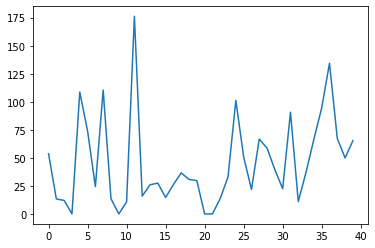

In [55]:
plt.plot(n_epe)

## categories

In [56]:
sub_id = 6
surge_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_surgeWINDOW_induced_flag.npy")
# tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced_flag.npy")
tutt_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_TUTT_induced-10degree.npy")
# tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_induced_flag.npy")
tc_induced_flag = np.load("ERA5/PAU/" + str(sub_id) + "_tc_corrected_flag.npy")
MCS_induced_flag = np.load("ERA5/PAU/MCS_" + str(sub_id) + ".npy")
MCS_induced_flag[MCS_induced_flag < 0] = 0
midtro_flag = np.load("ERA5/PAU/" + str(sub_id) + "_midTropo.npy")
front_flag = np.load("ERA5/PAU/" + str(sub_id) + "_front.npy")
start, end = start_end_time(sub_id)
all_time = ext_days[sub_id]

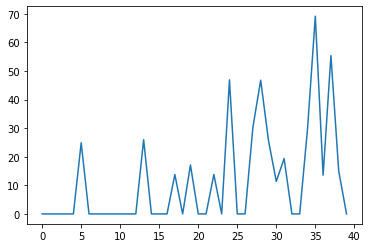

40
0.002104804670950866 True increasing
0.0 0.0


In [57]:
precip_year = find_categories_precip(tc_induced_flag, end, sub_id=6)
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

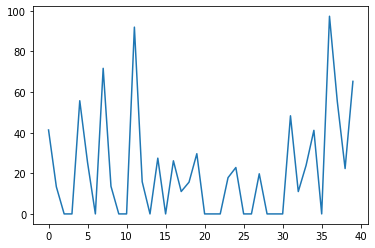

40
0.43302571403565326 False no trend
0.0 14.617186746560037


In [58]:
precip_year = find_categories_precip(tutt_induced_flag, end, sub_id=6)
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

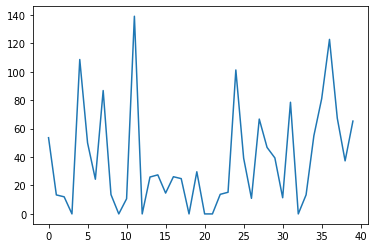

40
0.1119858434398513 False no trend
0.7093293624097816 12.222807757451513


In [59]:
precip_year = find_categories_precip(surge_induced_flag, end, sub_id=6)
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

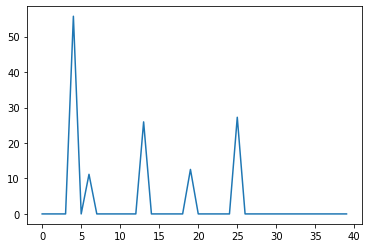

40
0.22147170645229464 False no trend
0.0 0.0


In [60]:
precip_year = find_categories_precip(midtro_flag, end, sub_id=6)
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

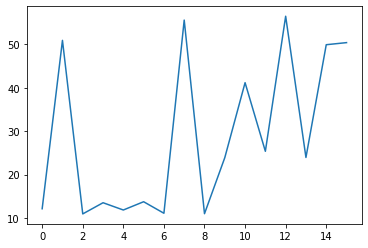

16
0.042763425833193924 False no trend
1.7811888036998522 10.566814003296065


In [61]:
precip_year = find_categories_precip(MCS_induced_flag, end, sub_id=6)
precip_year = precip_year[2003-1979:]
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

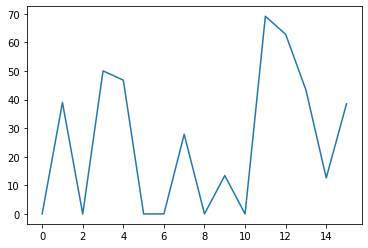

16
0.403869739467297 False no trend
0.9733904435072926 13.341326158455242


In [62]:
precip_year = find_categories_precip(front_flag, end, sub_id=6)
precip_year = precip_year[2003-1979:]
plt.plot(precip_year)
plt.show()

n = len(precip_year)
precip_year = np.array(precip_year)
s = mk_score(precip_year, n)
var_s = variance_s(precip_year, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05/6)
slope, intercept = sens_slope(precip_year)
print(p, h, trend)
print(slope, intercept)

# Sub7

In [63]:
sub_id = 7
n_epe = []
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
q1 = np.quantile(precip_data[precip_data > 1], 0.05)
q2 = np.quantile(precip_data[precip_data > 1], 0.95)

for year in range(1979, 2019):
    year_precip = precip.sel(time=precip.time.dt.year==year)
    ext_time = year_precip.where(year_precip > q2, drop=True).time.data
    ext_precip = year_precip.sel(time=ext_time)
    # print(len(ext_time), q2)
    n_epe.append(np.sum(ext_precip.data))
    
n = len(n_epe)
n_epe = np.array(n_epe)
s = mk_score(n_epe, n)
var_s = variance_s(n_epe, n)
Tau = s/(.5*n*(n-1))

z = z_score(s, var_s)
p, h, trend = p_value(z, alpha=0.05)
slope, intercept = sens_slope(n_epe)
print(p, h, trend)
print(slope, intercept)

X = np.arange(n).reshape(-1, 1)
y = n_epe

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

40
0.13577683650623618 False no trend
-1.35819106853177 121.87959361954304
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.777
Date:                Sat, 18 Jun 2022   Prob (F-statistic):              0.104
Time:                        10:33:02   Log-Likelihood:                -218.38
No. Observations:                  40   AIC:                             440.8
Df Residuals:                      38   BIC:                             444.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

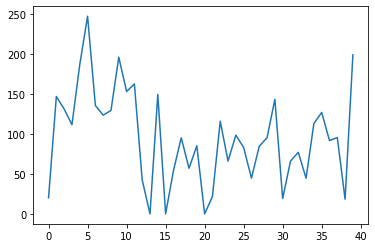

In [64]:
plt.plot(n_epe)